In [1]:
import sys
sys.path.append("..")

from services.segments_database import do_query
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion
import numpy as np
import scipy
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, recall_score, roc_curve, precision_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm
import matplotlib.pyplot as plt


# Config

In [18]:
relevant_topic = 9
number_of_training_data = 1000
relevant_columns = ['header_preprocessed', 'parent_preprocessed', 'grandparent_preprocessed', 'words']
category = 'zk'

## get training data

show topic

In [3]:
topic = do_query("select * from topic where id = {0}".format(relevant_topic))
topic.fetchall()

[(9, 'zuschlagskriterium preis bewertung zk gewichtung eignungsund evaluation punkt kriterium qualität')]

In [19]:
query = '''
SELECT *, GROUP_CONCAT(word.word SEPARATOR ' ') as words
FROM trainingdata INNER JOIN word ON trainingdata.id = word.chapter_id
WHERE label IS NOT NULL
AND category = {0}
GROUP BY trainingdata.id
'''.format(category)

result = do_query(query)
training_data = pd.DataFrame(result.fetchall())
training_data.columns = result.keys()
training_data.shape

OperationalError: (MySQLdb._exceptions.OperationalError) (1054, "Unknown column 'category' in 'where clause'")
[SQL: 
SELECT *, GROUP_CONCAT(word.word SEPARATOR ' ') as words
FROM trainingdata INNER JOIN word ON trainingdata.id = word.chapter_id
WHERE label IS NOT NULL
AND category = zk
GROUP BY trainingdata.id
]
(Background on this error at: http://sqlalche.me/e/e3q8)

In [5]:
training_data.head()

,id,text,chapter_idx,chapter_number,header,header_preprocessed,parent_header,parent_preprocessed,grandparent_header,grandparent_preprocessed,...,label,suggested_label,createdAt,updatedAt,id,word,tfidf,score,chapter_id,words
0,1,\nStaatskanzlei\n\nRathaus 8750 Glarus\n\nTele...,0,None,\n,,,,,,...,no,0,2019-04-30 14:00:54,2019-04-30 14:58:34,1,055,0.424899,2.0,1,055 09 11 12 15 60 646 8750 fax glarus mail ra...
1,2,\nAusschreibungsgegenstand\n\nDer Kanton Glaru...,1,1,Ausschreibung; Arbeiten zur Installation und z...,ausschreibung arbeit installation betrieb elek...,,,,,...,no,0,2019-04-30 14:00:54,2019-04-30 14:58:56,15,aktiv,0.102934,12.0,2,aktiv anforderung anforderungsbereich dabei do...
2,3,\nDer Regierungsrat will die elektronische Sti...,2,2,Ziele Projektziele:\n,ziel projektziel,,,,,...,no,0,2019-04-30 14:00:54,2019-04-30 15:02:53,35,2018,0.136370,218.0,3,2018 2019 ausschreibung bund e elektronisch gl...
3,4,"\nEs wird vorausgesetzt, dass der Anbieter gen...",3,3,Marktpositionierung und Rolle des Anbieters\n,marktpositionierung rolle anbieters,,,,,...,no,0,2019-04-30 14:00:54,2019-04-30 15:03:07,54,anbieter,0.198733,296.0,4,anbieter bereitstellung betrieb dass e genügen...
4,5,\nDie nachfolgende Grafik zeigt die Abgrenzung...,4,4,Systemabgrenzung\n,systemabgrenzung,,,,,...,no,0,2019-04-30 14:00:54,2019-04-30 15:05:42,66,abgrenzung,0.132285,4.0,5,abgrenzung aktivität bestehen betreiben datens...


## split into training- and test data

In [6]:
X = training_data[relevant_columns]
X.head()

,header_preprocessed,parent_preprocessed,grandparent_preprocessed,words
0,,,,055 09 11 12 15 60 646 8750 fax glarus mail ra...
1,ausschreibung arbeit installation betrieb elek...,,,aktiv anforderung anforderungsbereich dabei do...
2,ziel projektziel,,,2018 2019 ausschreibung bund e elektronisch gl...
3,marktpositionierung rolle anbieters,,,anbieter bereitstellung betrieb dass e genügen...
4,systemabgrenzung,,,abgrenzung aktivität bestehen betreiben datens...


In [7]:
# get df, not series
y = training_data.loc[:,['label']]
y.loc[y['label'] == 'yes'] = 1
y.loc[y['label'] == 'no'] = 0
# convert to series
y = y['label']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## make tfidf and train model

In [9]:
words_vec = TfidfVectorizer()
words_tfidf = words_vec.fit_transform(X_train['words'])

header_vec = TfidfVectorizer()
header_tfidf = header_vec.fit_transform(X_train['header_preprocessed'])

parent_vec = TfidfVectorizer()
parent_tfidf = parent_vec.fit_transform(X_train['parent_preprocessed'])

grandparent_vec = TfidfVectorizer()
grandparent_tfidf = grandparent_vec.fit_transform(X_train['grandparent_preprocessed'])

X_train_union = scipy.sparse.hstack([
    words_tfidf,
    header_tfidf,
    parent_tfidf,
    grandparent_tfidf
])

union_features = words_vec.get_feature_names()\
               + header_vec.get_feature_names()\
               + parent_vec.get_feature_names()\
               + grandparent_vec.get_feature_names()


print(len(union_features))
print(X_train_union.shape)


1821
(225, 1821)


In [10]:
classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
classifier.fit(X_train_union, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

## prepare test data and test model

In [11]:
words_tfidf = words_vec.transform(X_test['words'])
header_tfidf = header_vec.transform(X_test['header_preprocessed'])
parent_tfidf = parent_vec.transform(X_test['parent_preprocessed'])
grandparent_tfidf = grandparent_vec.transform(X_test['grandparent_preprocessed'])

X_test_union = scipy.sparse.hstack([
    words_tfidf,
    header_tfidf,
    parent_tfidf,
    grandparent_tfidf
])

print(X_test_union.shape)

(57, 1821)


In [12]:
y_pred = classifier.predict(X_test_union)

In [13]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test,y_pred))  
print(accuracy_score(y_test, y_pred))  

[[47  2]
 [ 2  6]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        49
           1       0.75      0.75      0.75         8

   micro avg       0.93      0.93      0.93        57
   macro avg       0.85      0.85      0.85        57
weighted avg       0.93      0.93      0.93        57

0.9298245614035088


## plot ROC curve

In [14]:
# select second class only
y_pred_proba = classifier.predict_proba(X_test_union)[:,1]

y_train_pred = classifier.predict(X_train_union)
y_train_pred_proba = classifier.predict_proba(X_train_union)[:,1]

In [15]:
roc_value = roc_auc_score(y_test, y_pred_proba)
roc_value

0.9642857142857143

In [20]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
        
    baseline['recall'] = recall_score(test_labels, 
                                     [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, 
                                      [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); 
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show();

Recall Baseline: 1.0 Test: 0.75 Train: 1.0
Precision Baseline: 0.14 Test: 0.75 Train: 1.0
Roc Baseline: 0.5 Test: 0.96 Train: 1.0


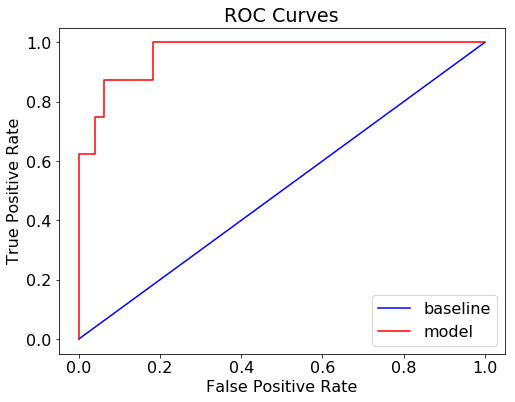

In [17]:
test_labels = y_test
train_labels = y_train
evaluate_model(y_pred, y_pred_proba, y_train_pred, y_train_pred_proba)